In [1]:
# Importing Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import chardet
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols, logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
import heapq
import re

In [2]:
# Importing data into notebook
sourcepath = 'D:\Work\Research\Dropbox\Machine Learning\Side Projects\Employee Churn IBM\employee_churn_prediction_ibm'
filepath = os.path.join(sourcepath, "data", "processed", "IBM_HR_Data_Cleaned.csv")

IBMData = pd.read_csv(filepath)

In [3]:
# Checking data head
IBMData.head(n=5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41.0,Yes,Travel_Rarely,1102.0,Sales,1.0,2,Life Sciences,1,2,...,3,1,0,8.0,0.0,1,6.0,4.0,0.0,5.0
1,49.0,No,Travel_Frequently,279.0,Research & Development,8.0,1,Life Sciences,2,3,...,4,4,1,10.0,3.0,3,10.0,7.0,1.0,7.0
2,37.0,Yes,Travel_Rarely,1373.0,Research & Development,2.0,2,Other,4,4,...,3,2,0,7.0,3.0,3,0.0,0.0,0.0,0.0
3,33.0,No,Travel_Frequently,1392.0,Research & Development,3.0,4,Life Sciences,5,4,...,3,3,0,8.0,3.0,3,8.0,7.0,3.0,0.0
4,27.0,No,Travel_Rarely,591.0,Research & Development,2.0,1,Medical,7,1,...,3,4,1,6.0,3.0,3,2.0,2.0,2.0,2.0


In [4]:
# Checking variables in the IBM Data 
#IBMData.dtypes

In [5]:
# Remove the column 'EmployeeNumber' since this identifies each employee by a unique number and each employee appears only once 
IBMData.drop(['EmployeeNumber'], axis = 1, inplace = True)

In [6]:
# Then make sure that some of the important variables are in float form, even if they have an int64 type
numvars = ['Age','DailyRate','DistanceFromHome','HourlyRate','MonthlyIncome','MonthlyRate','NumCompaniesWorked', 
          'PercentSalaryHike','PerformanceRating','TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany',
          'YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager']
IBMData[numvars] = IBMData[numvars].apply(pd.to_numeric, axis = 1, downcast = 'float') 

# Now generate a binary indicator for the attrition variable
IBMData['Left'] = (IBMData.Attrition=='Yes')*1

# Now convert the remaining variables into categorical variables/object variables
catvars = [item for item in IBMData.columns.to_list() if item not in numvars and item != 'Attrition' and item != 'Left']
IBMData[catvars] = IBMData[catvars].astype('category')

# Now remove the attrition variable
IBMData.drop(['Attrition'], axis = 1, inplace = True)

In [7]:
# Check data types of columns again
#IBMData.dtypes

In [8]:
# Now split the data into X and Y
Y = IBMData.Left.copy(deep=True)
X = IBMData.loc[:, IBMData.columns != 'Left'].copy(deep = True)
print('Shapes of the dependent and independent variables respectively: ', Y.shape, X.shape)

Shapes of the dependent and independent variables respectively:  (1470,) (1470, 30)


In [9]:
# Now change levels in some categorical variables to shorter or more interpretable names

X['BusinessTravel'].cat.rename_categories(
    {'Travel_Rarely':'TravelRare','Travel_Frequently':'TravelFreq','Non-Travel':'TravelNo'}, inplace = True)
X['Department'].cat.rename_categories(
    {'Research & Development':'R&D','Sales':'Sales','Human Resources':'HR'}, inplace = True)
X['EducationField'].cat.rename_categories(
    {'Life Sciences':'LifeSc','Technical Degree':'Technical','Human Resources':'EducHR'}, inplace = True)
X['JobRole'].cat.rename_categories(
    {'Sales Executive':'SalexExec','Research Scientist':'Scientist','Laboratory Technician':'LabTech',
    'Manufacturing Director':'ManufDir','Healthcare Representative':'HealthRep','Sales Representative':'SalesRep',
    'Research Director':'ResDir','Human Resources':'RoleHR'}, inplace = True)

In [10]:
# Now convert categorical variables into dummies and then drop one base level 
Xnumvars = X[[item for item in X.columns.to_list() if X[item].dtypes == 'float32']]
Xcatvars = X[[item for item in X.columns.to_list() if hasattr(X[item], 'cat')]]  

# Now generate the dummies
Xcatvars = pd.get_dummies(data = Xcatvars, drop_first = False)
# Now drop the base levels by selecting an appropriate base level
Xcatvars.drop(['BusinessTravel_TravelNo','Department_HR','Education_1','EducationField_Other','EnvironmentSatisfaction_1',
              'Gender_Female','JobInvolvement_1','JobLevel_1','JobSatisfaction_1','JobRole_RoleHR','MaritalStatus_Single',
              'OverTime_No','RelationshipSatisfaction_1','StockOptionLevel_0','WorkLifeBalance_1'], axis = 1, inplace = True)

# Now bind the datasets together
X1 = pd.concat([Xnumvars, Xcatvars], axis = 1)

### (1) Linear Probability Model Regressions

#### (1.a) LPM Regressions with no interaction variables

Estimated Coefficients from Linear Probability Model with No Interaction Terms:
                    Coefficients
Age                    -0.003650
DailyRate              -0.000034
DistanceFromHome        0.003958
HourlyRate             -0.000094
MonthlyIncome          -0.000010
...                          ...
StockOptionLevel_3     -0.048175
WorkLifeBalance_2      -0.118201
WorkLifeBalance_3      -0.155609
WorkLifeBalance_4      -0.106715
Constant                0.754617

[63 rows x 1 columns]
R-squared value of the fitted mode: 0.29920117274299185


Text(0.5, 0, 'Residuals')

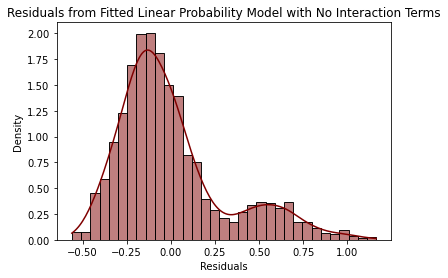

In [11]:
# Create Model Object
LPM_NoInteract = LinearRegression()

# Fit the model to the data
LPM_NoInteract.fit(X1,Y)

# Print the intercept and the model parameters
LPM_NoInteract_Coefs = pd.DataFrame(np.append(LPM_NoInteract.coef_,LPM_NoInteract.intercept_), 
                                    index = X1.columns.to_list()+['Constant'], 
                                    columns = ['Coefficients'])
print('Estimated Coefficients from Linear Probability Model with No Interaction Terms:')
print(LPM_NoInteract_Coefs) 

# Printing the R-squared value
print('R-squared value of the fitted mode:', LPM_NoInteract.score(X1,Y))

# To predict using this model
#LPM_NoInteract.predict(TestX)

# To find the residuals of this model
residuals = Y - LPM_NoInteract.predict(X1)
# Plot the residuals in a histogram
g = sns.histplot(residuals, stat = 'density', kde = True, color = 'maroon')
g.set_title('Residuals from Fitted Linear Probability Model with No Interaction Terms')
g.set_xlabel('Residuals')

In [12]:
## Implementing LPM Alternatively Using StatsModels Package

# Add a constant
X_SM = sm.add_constant(X1)
LPM_NoInteract_SM = sm.OLS(Y,X_SM).fit()

print('Summary of model fit:')
print(LPM_NoInteract_SM.summary())

# Finding all the attritbute names in the model results
# for attr in dir(LPM_NoInteract_SM):
#     if not attr.startswith('_'):
#         print(attr)

Summary of model fit:
                            OLS Regression Results                            
Dep. Variable:                   Left   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     9.712
Date:                Fri, 26 Feb 2021   Prob (F-statistic):           6.08e-72
Time:                        16:49:45   Log-Likelihood:                -353.44
No. Observations:                1470   AIC:                             832.9
Df Residuals:                    1407   BIC:                             1166.
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [12]:
#X.columns

In [14]:
## Alternative Way of Implementing Linear Regression Replicating R-style formula

# Define the formula first
formula = ('Left ~ Age + DailyRate + DistanceFromHome + HourlyRate + MonthlyIncome + MonthlyRate + NumCompaniesWorked + ' +
          'PercentSalaryHike + PerformanceRating + TotalWorkingYears + TrainingTimesLastYear + YearsAtCompany + ' +
          'YearsInCurrentRole + YearsSinceLastPromotion + YearsWithCurrManager + ' + 
          'C(BusinessTravel, Treatment(reference = "TravelNo")) + C(Department, Treatment(reference = "HR")) + ' + 
          'C(Education, Treatment(reference = 1)) + C(EducationField, Treatment(reference = "EducHR")) + ' + 
          'C(EnvironmentSatisfaction, Treatment(reference = 1)) + C(Gender, Treatment(reference="Female")) + ' +
          'C(JobInvolvement, Treatment(reference = 1)) + C(JobLevel, Treatment(reference=1)) + ' + 
          'C(JobSatisfaction, Treatment(reference=1)) + C(JobRole, Treatment(reference="RoleHR")) + ' + 
          'C(MaritalStatus, Treatment(reference="Single")) + C(OverTime, Treatment(reference="No")) + ' + 
          'C(RelationshipSatisfaction, Treatment(reference=1)) + C(StockOptionLevel, Treatment(reference=0)) + ' + 
          'C(WorkLifeBalance, Treatment(reference=1))')  

LPM_NoInteract_SMF = smf.ols(data = pd.concat([Y,X], axis = 1), formula = formula).fit()

print('Estimated Coefficients and Other Details:')
LPM_NoInteract_SMF.summary()

# # Finding all the attritbute names in the model results
# for attr in dir(LPM_NoInteract_SMF):
#     if not attr.startswith('_'):
#         print(attr)

Estimated Coefficients and Other Details:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Left   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     9.712
Date:                Fri, 26 Feb 2021   Prob (F-statistic):           6.08e-72
Time:                        16:50:19   Log-Likelihood:                -353.44
No. Observations:                1470   AIC:                             832.9
Df Residuals:                    1407   BIC:                             1166.
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                            0.8975      0.137      6.536      0.000       0.628       1.167
C(BusinessTravel, Treatment(reference="TravelNo"))[T.TravelFreq]     0.1558      0.032      4.802      0.000       0.092       0.220
C(BusinessTravel, Treatment(reference="TravelNo"))[T.TravelRare]     0.0658      0.028      2.343      0.019       0.011       0.121
C(Department, Treatment(reference="HR"))[T.R&D]                      0.1151      0.115      0.999      0.318      -0.111       0.341
C(Department, Treatment(reference="HR"))[T.Sales]                    0.0830      0.120      0.695      0.487      -0.151       0.317
C(Education, Treatment(reference=1))[T.2]                            0.0426      0.032      1.348      0.178      -0.019       0.105
C(Education, Treatment(reference=1))[T.3]                            0.0345      0.028      1.215      0.224      -0.021       0.090
C(Education, Treatment(reference=1))[T.4]                            0.0330      0.030      1.089      0.277      -0.026       0.093
C(Education, Treatment(reference=1))[T.5]                            0.0173      0.053      0.325      0.745      -0.087       0.121
C(EducationField, Treatment(reference="EducHR"))[T.LifeSc]          -0.1154      0.083     -1.398      0.162      -0.277       0.047
C(EducationField, Treatment(reference="EducHR"))[T.Marketing]       -0.0704      0.088     -0.801      0.424      -0.243       0.102
C(EducationField, Treatment(reference="EducHR"))[T.Medical]         -0.1294      0.083     -1.562      0.119      -0.292       0.033
C(EducationField, Treatment(reference="EducHR"))[T.Other]           -0.1327      0.089     -1.495      0.135      -0.307       0.041
C(EducationField, Treatment(reference="EducHR"))[T.Technical]       -0.0209      0.086     -0.242      0.809      -0.190       0.148
C(EnvironmentSatisfaction, Treatment(reference=1))[T.2]             -0.1085      0.027     -4.049      0.000      -0.161      -0.056
C(EnvironmentSatisfaction, Treatment(reference=1))[T.3]             -0.1224      0.024     -5.044      0.000      -0.170      -0.075
C(EnvironmentSatisfaction, Treatment(reference=1))[T.4]             -0.1276      0.024     -5.238      0.000      -0.175      -0.080
C(Gender, Treatment(reference="Female"))[T.Male]                     0.0308      0.017      1.799      0.072      -0.003       0.064
C(JobInvolvement, Treatment(reference=1))[T.2]                      -0.1517      0.039     -3.905      0.000      -0.228      -0.075
C(JobInvolvement, Treatment(reference=1))[T.3]                      -0.1857      0.037     -5.042      0.000      -0.258      -0.113
C(JobInvolvement, Treatm

In [15]:
## Checking for multicollinearity among independent variables using Variance Inflation Factor (VIF)

## Do the following:
# First, compute the VIF for all numeric variables in the data
# Second, order these VIF values from largest to smallest and get rid of the largest. 
# Third, drop the variable with largest VIF if the largest VIF >= 10
# Fourth, repeat steps 1-3 till largest VIF value < 10

largestVIF = 11.
Xalt = X[[item for item in X.columns.to_list() if X[item].dtypes == 'float32']].copy(deep=True)
while(largestVIF >= 10.):
    VIF = pd.DataFrame()
    VIF['Variables'] = Xalt.columns
    VIF['VIF'] = [variance_inflation_factor(Xalt.values, i) for i in range(Xalt.shape[1])]
    largestVIF = max(VIF['VIF'])
    if(largestVIF >= 10.):
        Xalt.drop([VIF.Variables[VIF['VIF'].idxmax()]], axis = 1, inplace = True)
        print('Largest VIF value >= 10.0')
        print('Dropping Variable: '+ str(VIF.Variables[VIF['VIF'].idxmax()]))

print()        
print('Final List of Numeric Variables Remaining in Data:')        
print(Xalt.columns.to_list())

Largest VIF value >= 10.0
Dropping Variable: PerformanceRating
Largest VIF value >= 10.0
Dropping Variable: Age
Largest VIF value >= 10.0
Dropping Variable: PercentSalaryHike
Largest VIF value >= 10.0
Dropping Variable: TotalWorkingYears

Final List of Numeric Variables Remaining in Data:
['DailyRate', 'DistanceFromHome', 'HourlyRate', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [16]:
# Reconstructing X using the remaining numeric variables and the categorical variables
# Important categorical variables to include 
catvars2include = ['BusinessTravel','Education','Gender','JobSatisfaction','JobRole','Department', 
                   'OverTime','JobLevel','WorkLifeBalance','StockOptionLevel']
Xalt = pd.concat([Xalt, X[catvars2include]], axis = 1)

In [17]:
## To improve the interpretability of the coefficients and also to improve comparisons of the coefficients across 
## variables conduct a logistic regression which will help estimate the increase in likelihood with each marginal 
## change of the variables. 
formula = ('Left ~ DailyRate + DistanceFromHome + HourlyRate + MonthlyIncome + MonthlyRate + NumCompaniesWorked + ' +
          'TrainingTimesLastYear + YearsAtCompany + ' +
          'YearsInCurrentRole + YearsSinceLastPromotion + YearsWithCurrManager + ' + 
          'C(BusinessTravel, Treatment(reference = "TravelNo")) + C(Department, Treatment(reference = "HR")) + ' + 
          'C(Education, Treatment(reference = 1)) + C(Gender, Treatment(reference="Female")) + ' + 
          'C(JobSatisfaction, Treatment(reference=1)) + C(JobLevel, Treatment(reference=1)) + ' + 
          'C(StockOptionLevel, Treatment(reference=0)) + C(OverTime, Treatment(reference="No")) + ' + 
          'C(WorkLifeBalance, Treatment(reference=1))')

Logit_NoInteract = logit(formula, pd.concat([Xalt, Y], axis = 1)).fit(maxiter = 2000)

# Now print the estimated coefficients from the Logit Model
#print('Estimated Coefficients from Logit Model:')
#print(Logit_NoInteract.summary())

# Now print the ODDS ratio for each variable
print()
print('ODDs Ratio for each explanatory variable:')
print(round(np.exp(Logit_NoInteract.params),3))

# Now print the marginal effects of each variable at the overall level
print()
AME = Logit_NoInteract.get_margeff(at = 'overall', method = 'dydx') 
print('Average Marginal Effects of Each Variable:')
AME.summary()

Optimization terminated successfully.
         Current function value: 0.308528
         Iterations 8

ODDs Ratio for each explanatory variable:
Intercept                                                           1.230
C(BusinessTravel, Treatment(reference="TravelNo"))[T.TravelFreq]    5.504
C(BusinessTravel, Treatment(reference="TravelNo"))[T.TravelRare]    2.258
C(Department, Treatment(reference="HR"))[T.R&D]                     0.664
C(Department, Treatment(reference="HR"))[T.Sales]                   2.414
C(Education, Treatment(reference=1))[T.2]                           1.233
C(Education, Treatment(reference=1))[T.3]                           1.204
C(Education, Treatment(reference=1))[T.4]                           1.009
C(Education, Treatment(reference=1))[T.5]                           0.811
C(Gender, Treatment(reference="Female"))[T.Male]                    1.468
C(JobSatisfaction, Treatment(reference=1))[T.2]                     0.551
C(JobSatisfaction, Treatment(reference=1)

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                   Left
Method:                          dydx
At:                           overall
====================================================================================================================================
                                                                      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
C(BusinessTravel, Treatment(reference="TravelNo"))[T.TravelFreq]     0.1618      0.036      4.492      0.000       0.091       0.232
C(BusinessTravel, Treatment(reference="TravelNo"))[T.TravelRare]     0.0773      0.034      2.278      0.023       0.011       0.144
C(Department, Treatment(reference="HR"))[T.R&D]                     -0.0388      0.038     -1.034      0.301      -0.112       0.035
C(Department, Treatment(reference="HR"))[T.Sales]                    0.0836      0.039      2.127      0.033       0.007       0.161
C(Education, Treatment(reference=1))[T.2]                            0.0198      0.030      0.667      0.505      -0.038       0.078
C(Education, Treatment(reference=1))[T.3]                            0.0176      0.026      0.678      0.498      -0.033       0.069
C(Education, Treatment(reference=1))[T.4]                            0.0008      0.028      0.030      0.976      -0.054       0.056
C(Education, Treatment(reference=1))[T.5]                           -0.0198      0.057     -0.345      0.730      -0.132       0.093
C(Gender, Treatment(reference="Female"))[T.Male]                     0.0364      0.017      2.162      0.031       0.003       0.069
C(JobSatisfaction, Treatment(reference=1))[T.2]                     -0.0565      0.025     -2.298      0.022      -0.105      -0.008
C(JobSatisfaction, Treatment(reference=1))[T.3]                     -0.0531      0.022     -2.445      0.014      -0.096      -0.011
C(JobSatisfaction, Treatment(reference=1))[T.4]                     -0.1127      0.023     -4.929      0.000      -0.158      -0.068
C(JobLevel, Treatment(reference=1))[T.2]                            -0.1173      0.029     -4.104      0.000      -0.173      -0.061
C(JobLevel, Treatment(reference=1))[T.3]                             0.0069      0.056      0.125      0.901      -0.102       0.116
C(JobLevel, Treatment(reference=1))[T.4]                            -0.1140      0.104     -1.100      0.271      -0.317       0.089
C(JobLevel, Treatment(reference=1))[T.5]                             0.0701      0.131      0.536      0.592      -0.186       0.326
C(StockOptionLevel, Treatment(reference=0))[T.1]                    -0.1305      0.018     -7.258      0.000      -0.166      -0.095
C(StockOptionLevel, Treatment(reference=0))[T.2]                    -0.1263      0.033     -3.859      0.000      -0.190      -0.062
C(StockOptionLevel, Treatment(reference=0))[T.3]                    -0.0529      0.035     -1.530      0.126      -0.121       0.015
C(OverTime, Treatment(reference="No"))[T.Yes]                        0.1569      0.015     10.263      0.000       0.127       0.187
C(WorkLifeBalance, Treatment(reference=1))[T.2]                     -0.0911      0.033     -2.787      0.005      -0.155      -0.027
C(WorkLifeBalance, Treatment(reference=1))[T.3]                     -0.1270      0.030     -4.201      0.000      -0.186      -0.068
C(WorkLifeBalance, Treatment(reference=1))[T.4]                     -0.0861      0.037     -2.303      0.021      -0.159      -0.013
DailyRate                                                        -4.302e-05      2e-05     -2.153      0.031   -8.22e-05   -3.86e-06
DistanceFromHome                                                     0.0042      0.001      4.288      0.000       0.002       0.006
HourlyRate                            

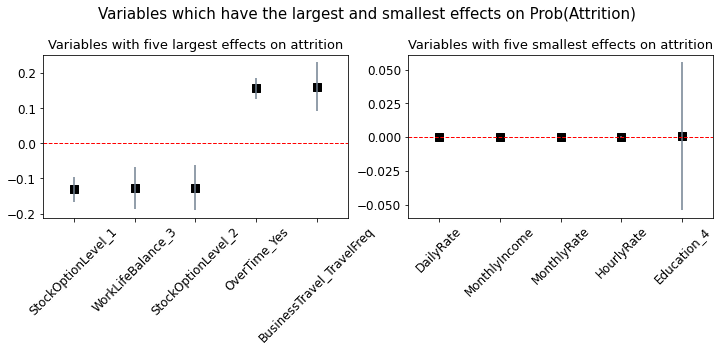

In [18]:
graphpath = os.path.join(sourcepath, "reports", "figures")
# Now sort the average marginal effects by their effects (dydx)
# Then plot the absolute largest 5 and absolute smallest 5 effects
# Keep in mind that these effects show how much the probability of leaving will change 

# First find the attributes in the AME object and then pick the correct attributes to compare. 
# for attr in dir(AME):
#     if not attr.startswith('_'):
#         print(attr)
        
# Now access the AME.summary_frame() and sort through the results
# Find the 5 absolute largest and 55 absolute smallest values along with variable names and confidence intervals
# Then place it in a dataframe

nlargestlist = heapq.nlargest(5, range(len(AME.margeff)), key = lambda x: abs(AME.margeff[x]))
nsmallestlist = heapq.nlargest(5, range(len(AME.margeff)), key = lambda x: -abs(AME.margeff[x]))
indexlist = nlargestlist + nsmallestlist

# Finding the columns in the AME.summary_frame() object
#print(AME.summary_frame().columns)

# Now use a function to populate the two dataframes with effects, confidence intervals, and corrected variable names
def populateframe(index, effects):
    frame = pd.DataFrame()
    frame['dy/dx'] = np.array(effects['dy/dx'])[index]
    frame['errors'] = (np.array(effects['Cont. Int. Hi.'])[index]-np.array(effects['Conf. Int. Low'])[index])/2.
    varnames = list(effects.index[index])
    for i, item in enumerate(varnames):
        if re.search(r'\(',item):
            varnames[i] = re.search(r'\((.+?),', item).group(1)+'_'+re.search(r'\.(.+?)\]',item).group(1)
            
    frame['Variables'] = varnames        
    return frame
framelargest = populateframe(nlargestlist, AME.summary_frame()).sort_values('dy/dx', ascending = True, axis = 0)
framesmallest = populateframe(nsmallestlist, AME.summary_frame()).sort_values('dy/dx', ascending = True, axis = 0) 
# Now plot the two sets of results in two adjacent subplots
#print(framelargest, framesmallest)

fig = plt.figure(figsize = (12, 3))
ax1 = plt.subplot(121)
framelargest.plot(x = 'Variables', y = 'dy/dx', kind = 'bar', ax = ax1, color = 'none', 
              fontsize = 20, ecolor = 'slategrey', capsize = 0, yerr = 'errors', legend = False)
ax1.scatter(x = pd.np.arange(framelargest.shape[0]), marker = 's', s = 80, y = framelargest['dy/dx'], color = 'black')
ax1.axhline(y = 0., linestyle = '--', color = 'red', linewidth = 1)
ax1.set_title('Variables with five largest effects on attrition', fontsize = 13)
ax1.set_xticklabels(framelargest['Variables'],fontsize=12, rotation = 45)
ax1.tick_params(axis = 'y', labelsize = 12)
ax1.set_xlabel('')
ax2 = plt.subplot(122)
framesmallest.plot(x = 'Variables', y = 'dy/dx', kind = 'bar', ax = ax2, color = 'none', 
              fontsize = 20, ecolor = 'slategrey', capsize = 0, yerr = 'errors', legend = False)
ax2.scatter(x = pd.np.arange(framesmallest.shape[0]), marker = 's', s = 80, y = framesmallest['dy/dx'], color = 'black')
ax2.axhline(y = 0., linestyle = '--', color = 'red', linewidth = 1)
ax2.set_title('Variables with five smallest effects on attrition', fontsize = 13)
ax2.set_xticklabels(framesmallest['Variables'],fontsize=12, rotation = 45)
ax2.tick_params(axis = 'y', labelsize = 12)
ax2.set_xlabel('')
plt.suptitle('Variables which have the largest and smallest effects on Prob(Attrition)', fontsize = 15, y = 1.1)
plt.show()
fig.savefig(os.path.join(graphpath, 'LogisticRegression_LargestSmallestEffects.png'))

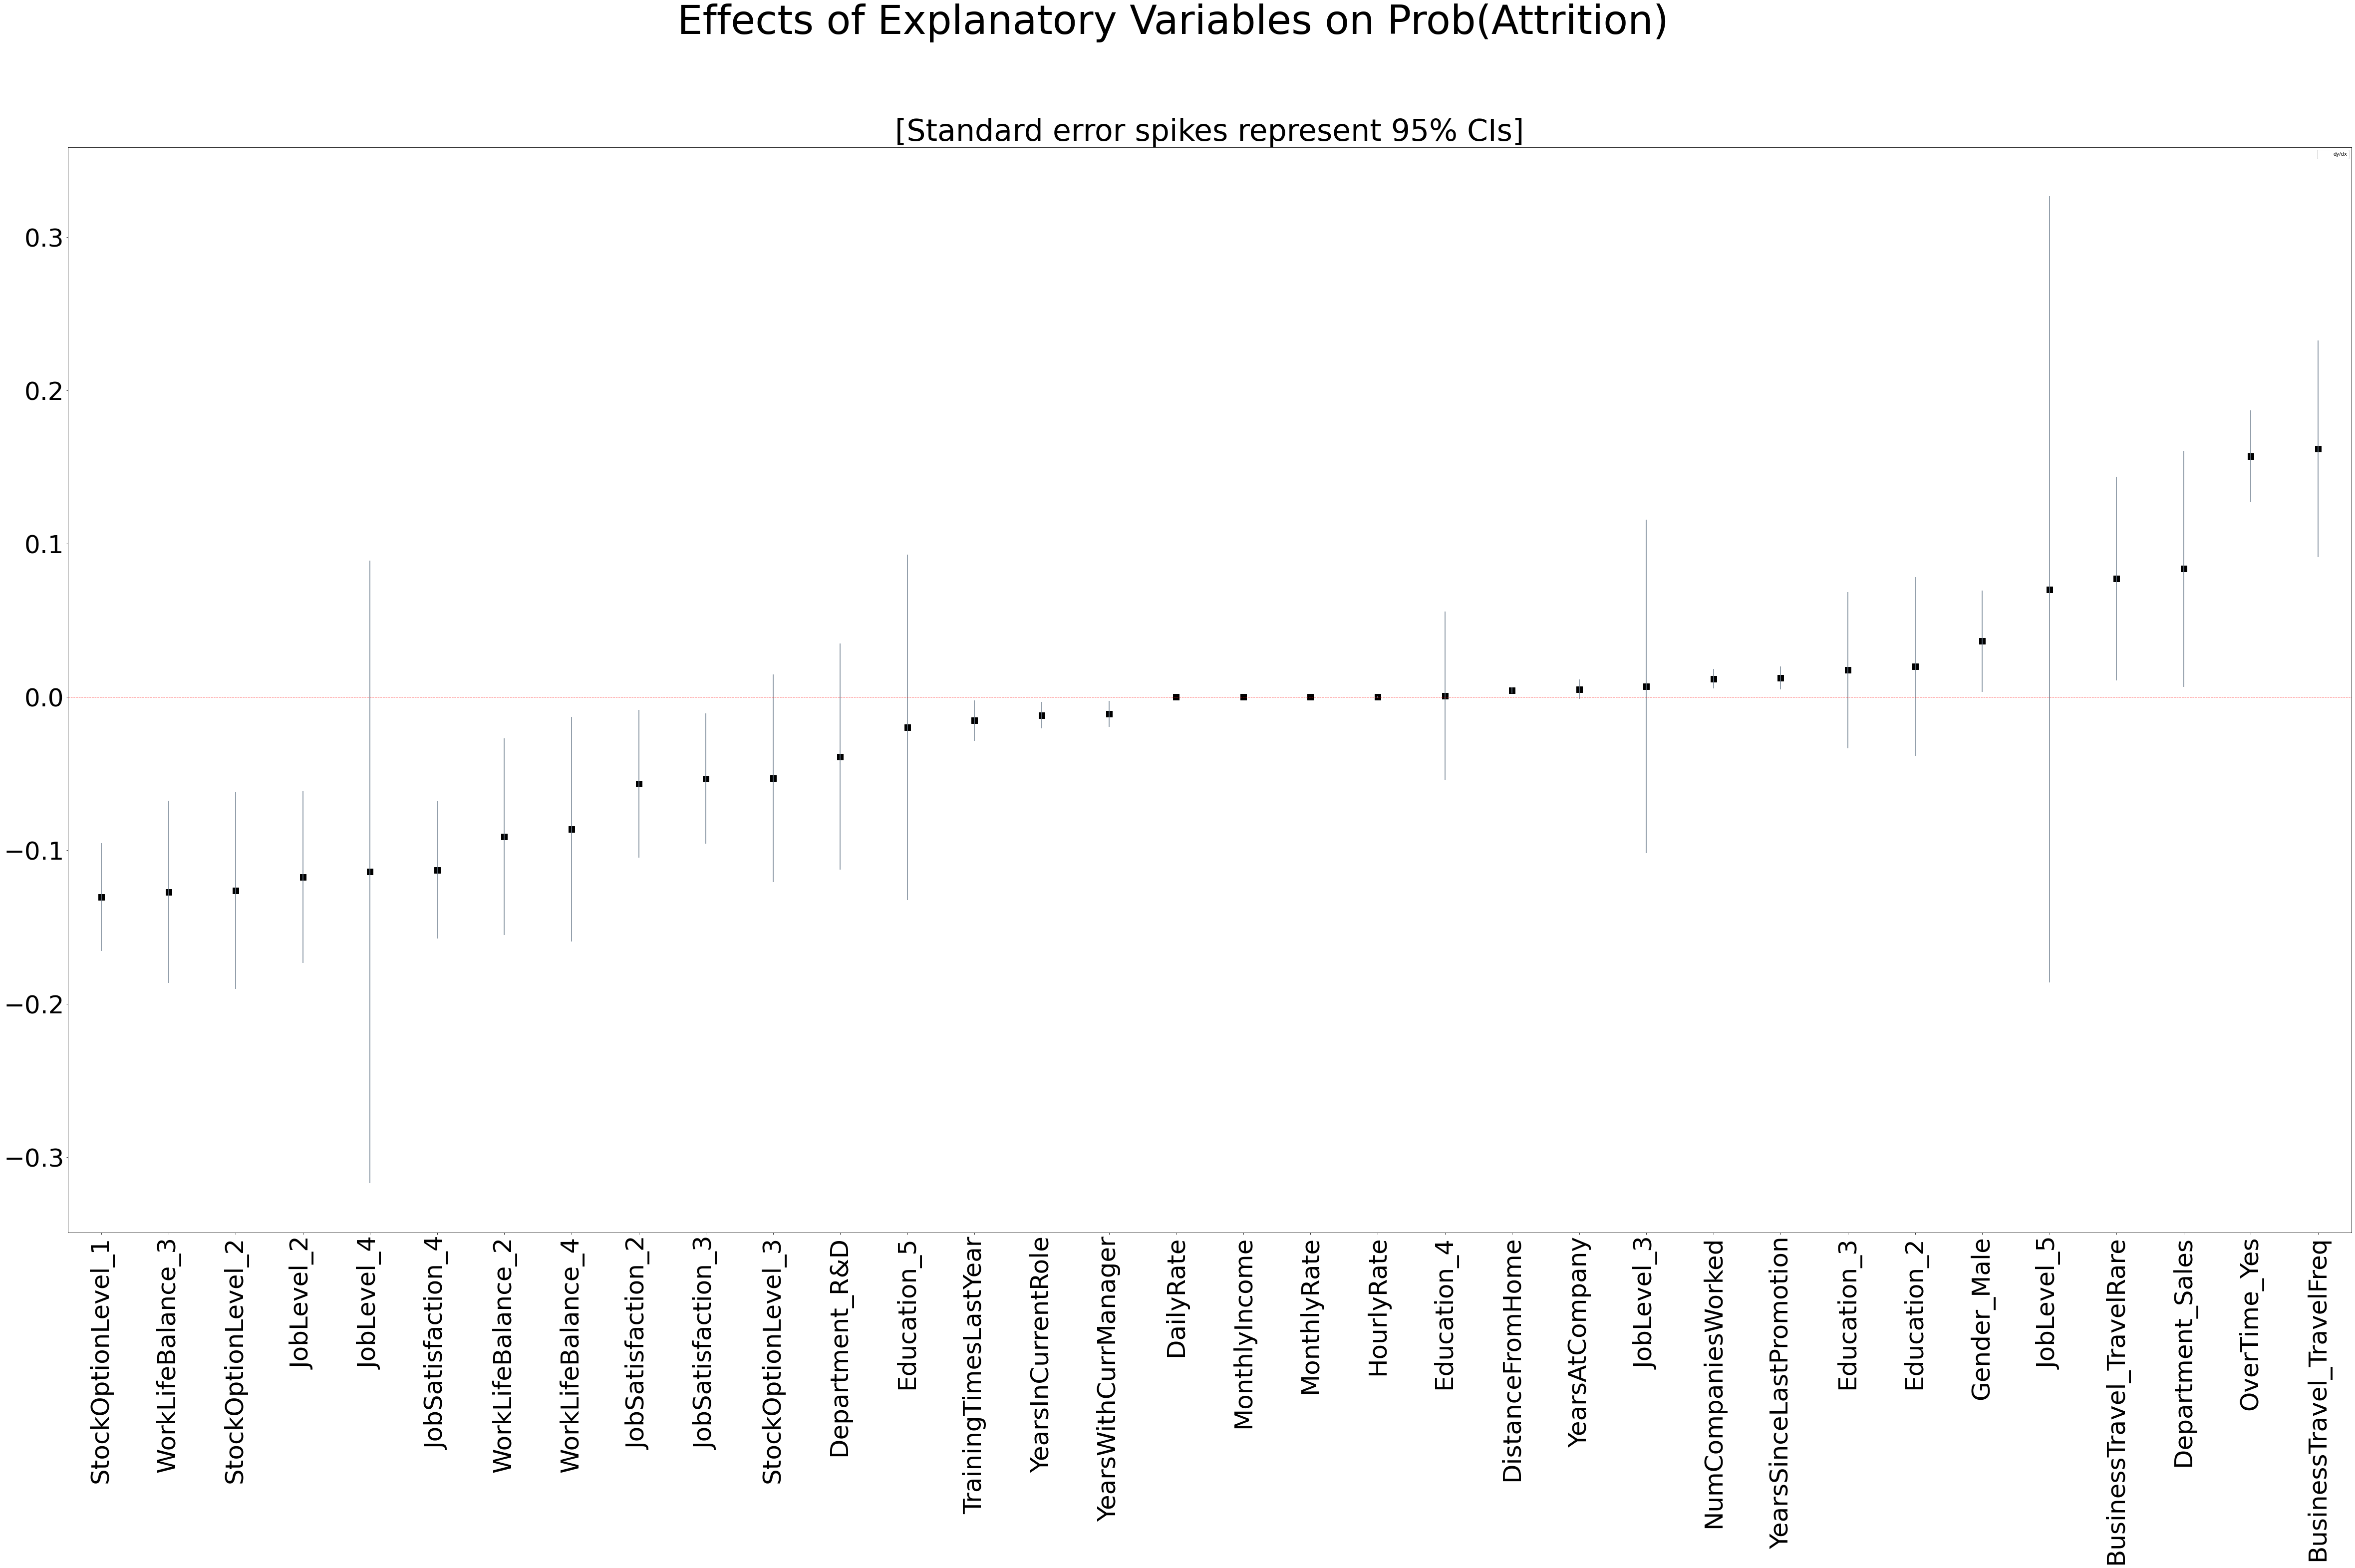

In [19]:
## Now plot all the effects in the same graph

framefull = populateframe(list(np.arange(len(AME.summary_frame()))), AME.summary_frame()).sort_values('dy/dx', ascending = True, axis = 0)
fig, ax = plt.subplots(figsize = (82, 40))
framefull.plot(x = 'Variables', y = 'dy/dx', kind = 'bar', color = 'none', capsize = 0, 
               yerr = 'errors', ax = ax, ecolor = 'slategrey', fontsize = 20)
ax.scatter(x = pd.np.arange(framefull.shape[0]), marker = 's', s = 150, y = framefull['dy/dx'], color = 'black')
ax.axhline(y = 0., linestyle = '--', color = 'red', linewidth = 1)
ax.set_title('[Standard error spikes represent 95% CIs]', fontsize = 60)
ax.set_xticklabels(framefull['Variables'], fontsize = 50)
ax.tick_params(axis = 'y', labelsize = 50)
ax.set_xlabel('')
plt.suptitle('Effects of Explanatory Variables on Prob(Attrition)', fontsize = 80)
fig.savefig(os.path.join(graphpath, 'LogisticRegression_Effects.png'))